# Sensitivity analysis of benchmark results

* input data ($P_{load}$ and $P_{sun}$): variability, length
* P_pv rated
* E_rated

Pierre Haessig, April 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Load testcase data

In [2]:
E_rated = 10 # kWh
P_pvp = 3 # kW
P_grid_max = 3 # kW

In [3]:
df = pd.read_csv('../data/data_2011-2012.csv', index_col=0, parse_dates=True)

# slice test weeks
df = df['2011-11-29':'2011-12-19'] # 3 weeks

n = len(df)
n//48

21

In [4]:
P_load = df.GC
P_sun = df.GG/1.04*P_pvp;

dt = 0.5 # hours
t = np.arange(n)*dt # hours
td = t/24 #days

In [5]:
print('Data from {} to {} ({:.0f} days)'. format(df.index.date[0], df.index.date[-1], td[-1]))
print('* average sun energy: {:.2f} kWh/d'.format(P_sun.mean()*24))
print('* average load      : {:.2f} kWh/d'.format(P_load.mean()*24))
print('* ratio sun/load: {:.2%}'.format(P_sun.mean()/P_load.mean()))

Data from 2011-11-29 to 2011-12-19 (21 days)
* average sun energy: 11.43 kWh/d
* average load      : 16.91 kWh/d
* ratio sun/load: 67.62%


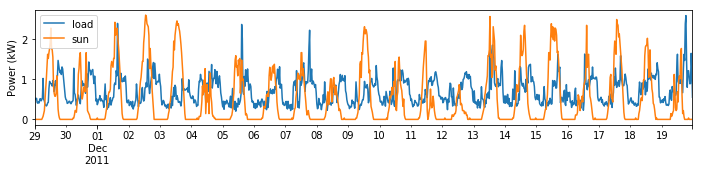

In [6]:
fig = plt.figure(figsize=(10,2.5))
P_load.plot(label='load')
P_sun.plot(label='sun')
plt.legend()
plt.ylabel('Power (kW)')
fig.tight_layout()

## Input data bootstrap

load bootstrap data generated in [data_variability_bootstrap.ipynb](../data/data_variability_bootstrap.ipynb)


*to be continued*

In [41]:
X = np.vstack([P_load, P_sun]).T
X.shape

(1584, 2)

In [48]:
Xb_list[0].shape

(336, 2)

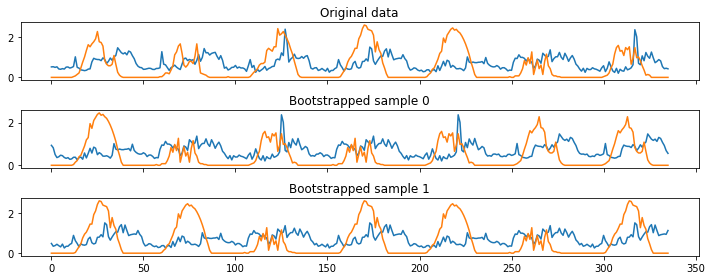

In [56]:
np.random.seed(0)
# number of samples
nsamp = 2

Xb_list = seasonal_block_bootstrap(X[:48*7,:], nsamp, 48, 3)

fig, ax = plt.subplots(3,1, sharex=True, figsize=(10,4))
ax[0].plot(X[:48*7,:])
ax[0].set_title('Original data')

ax[1].plot(Xb_list[0])
ax[1].set_title('Bootstrapped sample 0')

ax[2].plot(Xb_list[1])
ax[2].set_title('Bootstrapped sample 1')

fig.tight_layout()

### Stats on bootstrapped samples


In [136]:
# number of samples
nsamp = 300
print('nb of data points to generate: {:.1f} k'.format(nsamp * X.size/1000))

nb of data points to generate: 950.4 k


In [137]:
# block size (as nb of days)
blen = 5
np.random.seed(0)
Xb_list = seasonal_block_bootstrap(X, nsamp, 48, blen)

Save samples

In [148]:
Xb_stacked = np.hstack(Xb_list)
# plt.plot(Xb_stacked[:48*7, :4]) # check
Xb_stacked.shape

(1584, 600)

In [239]:
fname = 'test-data_{}_{:.0f}-days_bs-{}.csv'.format(df.index.date[0], td[-1], len(Xb_list))
fname

'test-data_2011-11-29_33-days_bs-300.csv'

In [218]:
X

array([[0.52 , 0.   ],
       [0.528, 0.   ],
       [0.496, 0.   ],
       ...,
       [0.45 , 0.   ],
       [0.542, 0.   ],
       [0.508, 0.   ]])

In [230]:
header = (['P_load_%d' % k, 'P_sun_%d' % k] for k in range(nsamp))
header = sum(header, [])
header = ','.join(header)
header[:50]

'P_load_0,P_sun_0,P_load_1,P_sun_1,P_load_2,P_sun_2'

In [238]:
with open(fname, 'w') as out:
    out.write(header+'\n')
    np.savetxt(out, Xb_stacked, fmt='%.9g', delimiter=',')

Cumulated energy for each sample (for load and for sun)

In [138]:
# truncate samples to see the effect of the length
ndays = 21

X_cumen = np.zeros((len(Xb_list), 2))
for k, Xb in enumerate(Xb_list):
    # truncate:
    Xb = Xb[:ndays*48,:]
    X_cumen[k,:] = Xb.mean(axis=0)*24 # kWh/day

P_load_cumen = X_cumen[:,0]
P_sun_cumen = X_cumen[:,1]
P_nl_cumen = P_load_cumen - P_sun_cumen

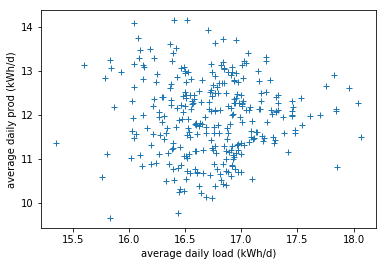

In [139]:
plt.plot(P_load_cumen, P_sun_cumen, '+')
plt.xlabel('average daily load (kWh/d)');
plt.ylabel('average daily prod (kWh/d)');

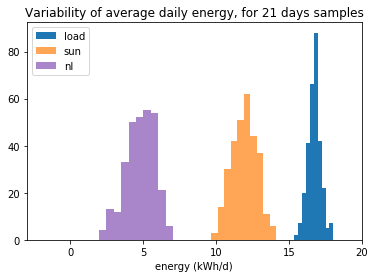

In [140]:
plt.title('Variability of average daily energy, for {} days samples'.format(ndays))
plt.hist(P_load_cumen, label='load')
plt.hist(P_sun_cumen, alpha=0.7, label='sun')
plt.hist(P_nl_cumen, color='tab:purple', alpha=0.8, label='nl')
plt.legend()
plt.xlabel('energy (kWh/d)')
plt.xlim(-3, 20);
plt.savefig('var_daily_ener_d{}.png'.format(ndays), dpi=150)

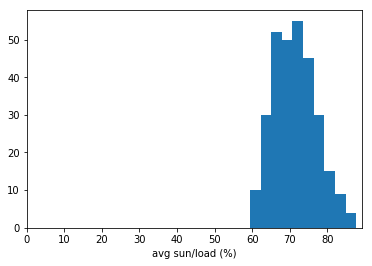

In [141]:
plt.hist(P_sun_cumen/P_load_cumen*100);
plt.xlim(xmin=0)
plt.xlabel('avg sun/load (%)');

### Effect of sample length

In [211]:
# block size (as nb of days)
blen = 3
np.random.seed(0)
Xb_list = seasonal_block_bootstrap(X, nsamp, 48, blen)

In [212]:
ndays_list = np.array([1, 2, 3, 4, 5, 7, 10, 14, 21, 33])

std_ndays = []

for ndays in ndays_list:
    X_cumen = np.zeros((len(Xb_list), 2))
    for k, Xb in enumerate(Xb_list):
        # truncate:
        Xb = Xb[:ndays*48,:]
        X_cumen[k,:] = Xb.mean(axis=0)*24 # kWh/day
    P_load_cumen = X_cumen[:,0]
    P_sun_cumen = X_cumen[:,1]
    P_nl_cumen = P_load_cumen - P_sun_cumen
    
    cumen_std = P_load_cumen.std(), P_sun_cumen.std(), P_nl_cumen.std()
    std_ndays.append(cumen_std)
    
std_ndays = pd.DataFrame(data=std_ndays, index=ndays_list, columns=['load', 'sun', 'nl'])
std_ndays.index.name = 'ndays'

#std_ndays

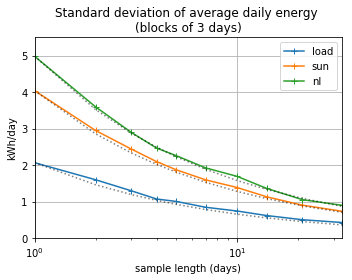

In [213]:
fig, ax = plt.subplots(figsize=(5,4))

std_ndays.plot(style='+-', ax=ax)
ax.plot(ndays_list, std_ndays.load[1]/np.sqrt(ndays_list), 'k:', alpha=0.5)
ax.plot(ndays_list, std_ndays.sun[1]/np.sqrt(ndays_list), 'k:', alpha=0.5)
ax.plot(ndays_list, std_ndays.nl[1]/np.sqrt(ndays_list), 'k:', alpha=0.5)

ax.set(
    title='Standard deviation of average daily energy \n(blocks of {} days)'.format(blen),
    xlabel='sample length (days)',
    xscale='log',
    #yscale='log',
    ylabel='kWh/day',
    ylim=(0, 5.5)
)
ax.grid(True)

fig.tight_layout()

#plt.savefig('std_daily_ener_bl{}.png'.format(blen), dpi=150)

Conclusion: it is not clear to me how to set the block length for the bootstrap. There seems to be a trade of

* short blocks (1-2 days):
  * `-` it necessarily kills the potential correlation between successive days.
  * `+` many different potential samples (ndays^nblocks)
* long blocks (5 days or more?):
  * `+` preserves the potential correlation between successive days.
  * `-` few potential different samples, so that the boot strapped statistics have a strong variability, despite the 300 samples

  

## Solar home simulation

using rule-based control, taken from [solar_home_rule-based-control.ipynb](../methods/python_rule-based/solar_home_rule-based-control.ipynb))

control strategy: battery should absorb absorb net production, as long as feasible:

$$P_{sto} = -P_{nl} = P_{sun} - P_{load}$$

In [9]:
def control(P_sun, P_load, E_sto):
    P_nl = P_load - P_sun
    # outputs:
    P_sto = 0
    P_grid = 0
    P_curt = 0
    
    E_next = E_sto - P_nl*dt
    
    if P_nl>0: # (load > sun)
        E_next = E_next if E_next>0. else 0.
        P_sto = (E_next - E_sto)/dt # <0
        P_grid = P_nl + P_sto
    else:
        E_next = E_next if E_next<E_rated else E_rated
        P_sto = (E_next - E_sto)/dt # >0
        P_curt = -P_nl - P_sto
    return P_sto, P_grid, P_curt

In [148]:
def home_sim(E_rated, P_pvp, )
# to be continued

P_sto = np.zeros(n)
E_sto = np.zeros(n+1)
P_grid = np.zeros(n)
P_curt = np.zeros(n)

E_sto[0]= E_rated/2

for k in range(n):
    P_sto[k], P_grid[k], P_curt[k] = control(P_sun[k], P_load[k], E_sto[k])
    E_sto[k+1] = E_sto[k] + P_sto[k]*dt
    assert 0 <= E_sto[k+1] <= E_rated

    
E_sto = E_sto[:-1]
P_pv = P_sun - P_curt
P_nl = P_load - P_sun

In [149]:
print('E_load: {:6.2f} kWh/d (data)'.format(P_load.mean()*24))
print('E_sun:  {:6.2f} kWh/d (data)'.format(P_sun.mean()*24))
print('E_pv:   {:6.2f} kWh/d'.format(P_pv.mean()*24))
print('E_curt: {:6.2f} kWh/d'.format(P_curt.mean()*24))
print('E_grid: {:6.2f} kWh/d'.format(P_grid.mean()*24))

E_load:  16.90 kWh/d (data)
E_sun:   12.71 kWh/d (data)
E_pv:    12.40 kWh/d
E_curt:   0.31 kWh/d
E_grid:   3.78 kWh/d


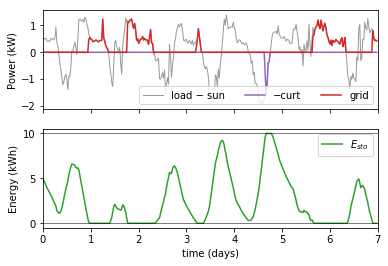

In [150]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(td, P_nl, label='load − sun',
           color=(0.6,)*3, lw=1)

ax[0].plot(td, -P_curt, label='−curt',
           color='tab:purple')

ax[0].plot(td, P_grid, label='grid',
           color='tab:red')

ax[0].legend(ncol=4)
ax[0].set(
    ylabel='Power (kW)'
)

ax[1].plot(td, E_sto, label='$E_{sto}$',
           color='tab:green');
ax[1].axhline(0, color='k', lw=0.5)
ax[1].axhline(E_rated, color='k', lw=0.5)

ax[1].legend()
ax[1].set(
    xlabel='time (days)',
    ylabel='Energy (kWh)',
    ylim=(-.05*E_rated, 1.05*E_rated),
    xlim=(0, n//48)
);